In [1]:
#importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
#load dataset
df = pd.read_csv('bank_transactions_data_2.csv')

In [3]:
#CLEANING

display(df.head())
target='TransactionAmount'
num_feat=['CustomerAge','TransactionDuration','LoginAttempts','AccountBalance']
cat_feat=['TransactionID','AccountID','TransactionDate','TransactionType','Location','DeviceID','MerchantID','Channel','CustomerOccupation']
all_feat=num_feat+cat_feat+[target]

# Drop missing values
df_clean=df[all_feat].dropna()

# Cleaning all the outliners
df_clean=df_clean[df_clean[target]>0]
Q1=df_clean[target].quantile(0.25)
Q3=df_clean[target].quantile(0.75)
IQR=Q3-Q1

df_clean=df_clean[(df_clean[target]>=(Q1-1.5*IQR)) & (df_clean[target]<=(Q3+1.5*IQR))]

# as transaction amount is continuous it continuos data, so we fake the model by creating an extra column of [isfraud] which stores the values of trasaction amount greater then 90% of the spending done by all users
threshold=df_clean[target].quantile(0.9)
df_clean['is_fraud']=(df_clean[target]>threshold).astype(int)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [4]:
# Splitting into X and y

X=df_clean[num_feat+cat_feat]
y=df_clean['is_fraud']

# Check value counts in the target variable before splitting
print("Value counts in y before split:")
print(y.value_counts())

Value counts in y before split:
is_fraud
0    2159
1     240
Name: count, dtype: int64


In [5]:
# Standardisation
scaler=StandardScaler()
# We need to apply the scaler to the numeric columns of X and keep the categorical ones separate for now
# Create a copy to avoid SettingWithCopyWarning
X_num = X[num_feat].copy() # we copy the cleaned dataset into another dataset variable to prevent modification to the orignal dataset
X_scaled_num = scaler.fit_transform(X_num)

In [6]:
# Encoding (convert datatype to int64)

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical = encoder.fit_transform(X[cat_feat])

In [7]:
# Cobining all processed data

X_final=np.hstack((X_scaled_num,X_categorical))

In [8]:
# TTS
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y,test_size=0.2, random_state=1,stratify=y)

# Check value counts in the training set after splitting
print("\nValue counts in y_train after split:")
print(y_train.value_counts())


Value counts in y_train after split:
is_fraud
0    1727
1     192
Name: count, dtype: int64


K MEANS CLUSTERING


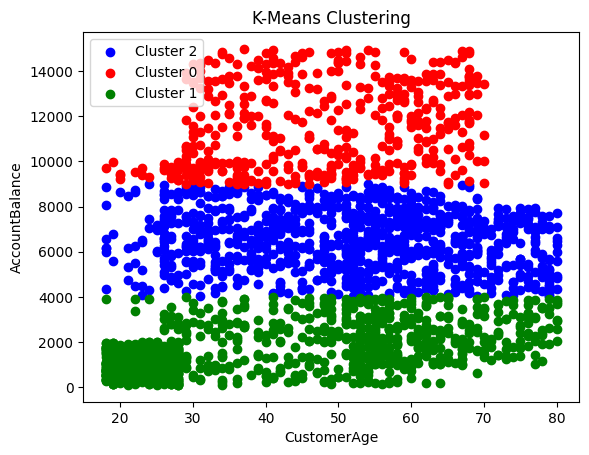

In [9]:
# K MEANS CLUSTERING
print('K MEANS CLUSTERING')

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['CustomerAge', 'AccountBalance']])


colors = ['red', 'green', 'blue']
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['CustomerAge'], cluster_data['AccountBalance'], label=f'Cluster {cluster}', color=colors[cluster])
plt.title("K-Means Clustering")
plt.xlabel('CustomerAge')
plt.ylabel('AccountBalance')
plt.legend()
plt.show()
